In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
replications = 1000    # число повторений Монте-Карло
sample_lengths = np.arange(10, 1000, 10)    # объем выборок, для которого будем вычислять 
                                            # ошибки 1 и 2 рода

### Процедура, вычисляющая значение статистики и решение в критерии Неймана-Пирсона

In [3]:
def neyman_pearson_compute(sample):
    r = 0.1               # хардкодим проверяемую гипотезу
    sigma = 1.0           # хардкодим проверяемую гипотезу
    n = len(sample)
    X_n = np.sum(sample)
    return r / sigma**2 * (X_n - r / 2.0 * n)

def neyman_pearson_decide(criterion_value):
    r = 0.1              # хардкодим проверяемую гипотезу
    return int(criterion_value > r / 2.0)# для проверки гипотезы о среднем значении
                                         # нормального распределения такой порог h
                                         # дает равные вероятности ошибки 1 и 2 рода

### Процедура, вычисляющая значение статистики и решение в последовательном критерии 

In [4]:
def wald_sprt_compute(sample):
    r = 0.1               # хардкодим проверяемую гипотезу
    sigma = 1.0           # хардкодим проверяемую гипотезу
    zetas = []
    for x in sample:
        zetas.append(r / sigma**2 * (x - r / 2.0))
    return np.cumsum(zetas)

def wald_sprt_decide(criterion_values, thresholds):
    A, B = thresholds
    for value_time, value in enumerate(criterion_values):
        if value >= B:
            return value_time, 1.0    # верна гипотеза H_1
        elif value <= A:
            return value_time, 0.0    # верна гипотеза H_0
        else:
            continue       # продолжать наблюдения
    return value_time, 0.0      # по умолчанию не отклоняем гипотезу H_0

Код вычисления статистик, относящихся к вероятностям 1 и 2 рода, для критерия Неймана-Пирсона, очень прост.

Для заданного объема выборки вычисляем долю ошибок 1 и 2 рода, она и равна приближенно вероятности этих ошибок.

In [11]:
neyman_pearson_alphas, neyman_pearson_betas = [], []
for sample_len in sample_lengths:
    neyman_pearson_p0_decisions = []
    neyman_pearson_p1_decisions = []
    for replication in xrange(replications):
        # для вычисления ошибки 1 рода (ложная тревога)
        # генерируем данные из гипотезы H_0 и вычисляем долю
        # решений в пользу гипотезы H_1: alpha = P(H_1 | H_0)
        
        p0_sample = np.random.normal(size=sample_len)
        neyman_pearson_value = neyman_pearson_compute(p0_sample)
        neyman_pearson_decision = neyman_pearson_decide(neyman_pearson_value)
        neyman_pearson_p0_decisions.append(neyman_pearson_decision)
        
        # для вычисления ошибки 2 рода (пропуск цели)
        # генерируем данные из гипотезы H_1 и вычисляем долю
        # решений в пользу гипотезы H_0: beta = P(H_0 | H_1)

        p1_sample = np.random.normal(loc=0.1, size=sample_len)
        neyman_pearson_value = neyman_pearson_compute(p1_sample)
        neyman_pearson_decision = neyman_pearson_decide(neyman_pearson_value)
        neyman_pearson_p1_decisions.append(neyman_pearson_decision)

    neyman_pearson_alphas.append(np.mean(neyman_pearson_p0_decisions))
    neyman_pearson_betas.append(1 - np.mean(neyman_pearson_p1_decisions))

Код вычисления статистик, относящихся к вероятностям 1 и 2 рода, для последовательного критерия отличается тем, что мы не знаем, сколько наблюдений фактически потребовалось для принятия решения. Чтобы вычислить долю истинных

In [13]:
wald_sprt_alphas = np.arange(0.01, 0.45, 0.01)
wald_sprt_betas = np.arange(0.01, 0.45, 0.01)
lower_thresholds = np.log(wald_sprt_betas / (1 - wald_sprt_alphas))
upper_thresholds = np.log((1 - wald_sprt_betas) / wald_sprt_alphas)

wald_sprt_p0_mean_decision_times = []
# wald_sprt_p1_decisions = defaultdict(list)

for A, B in zip(lower_thresholds, upper_thresholds):
    wald_sprt_p0_decisions = []
    wald_sprt_p0_decision_times = []

    for replication in xrange(replications):
        # для вычисления ошибки 1 рода (ложная тревога)
        # генерируем данные из гипотезы H_0 и вычисляем долю
        # решений в пользу гипотезы H_1: alpha = P(H_1 | H_0)
        p0_sample = np.random.normal(size=1000)
        wald_sprt_values = wald_sprt_compute(p0_sample)
        wald_sprt_decision_time, wald_sprt_decision = wald_sprt_decide(wald_sprt_values,
                                                                       thresholds=(A, B))
        wald_sprt_p0_decision_times.append(wald_sprt_decision_time)
        wald_sprt_p0_decisions.append(wald_sprt_decision)

    wald_sprt_p0_mean_decision_times.append(np.mean(wald_sprt_p0_decision_times))

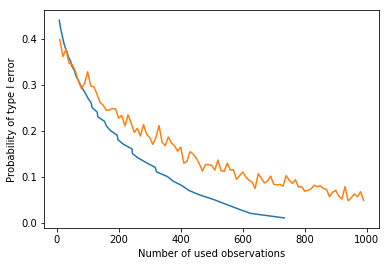

In [14]:
plot(wald_sprt_p0_mean_decision_times, wald_sprt_alphas, label='SPRT')
plot(sample_lengths, neyman_pearson_alphas, label='Neyman-Pearson')
xlabel('Number of used observations')
ylabel('Probability of type I error')

In [ ]:
plot(sample_lengths, neyman_pearson_alphas, label='Neyman-Pearson')
xlabel('Number of used observations')
ylabel('Probability of type I error')

In [ ]:
plot(sample_lengths, neyman_pearson_betas, label='Neyman-Pearson')
xlabel('Number of used observations')
ylabel('Probability of type II error')